In [62]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os

import numpy as np
from utils.utils import get_MNIST_dataset, onehot_decode_mnist_labels, show_images, skip_if
from sklearn.model_selection import train_test_split

## Test PyTorch for classification task

In [ ]:
LOAD_FROM_FILE = True

In [63]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


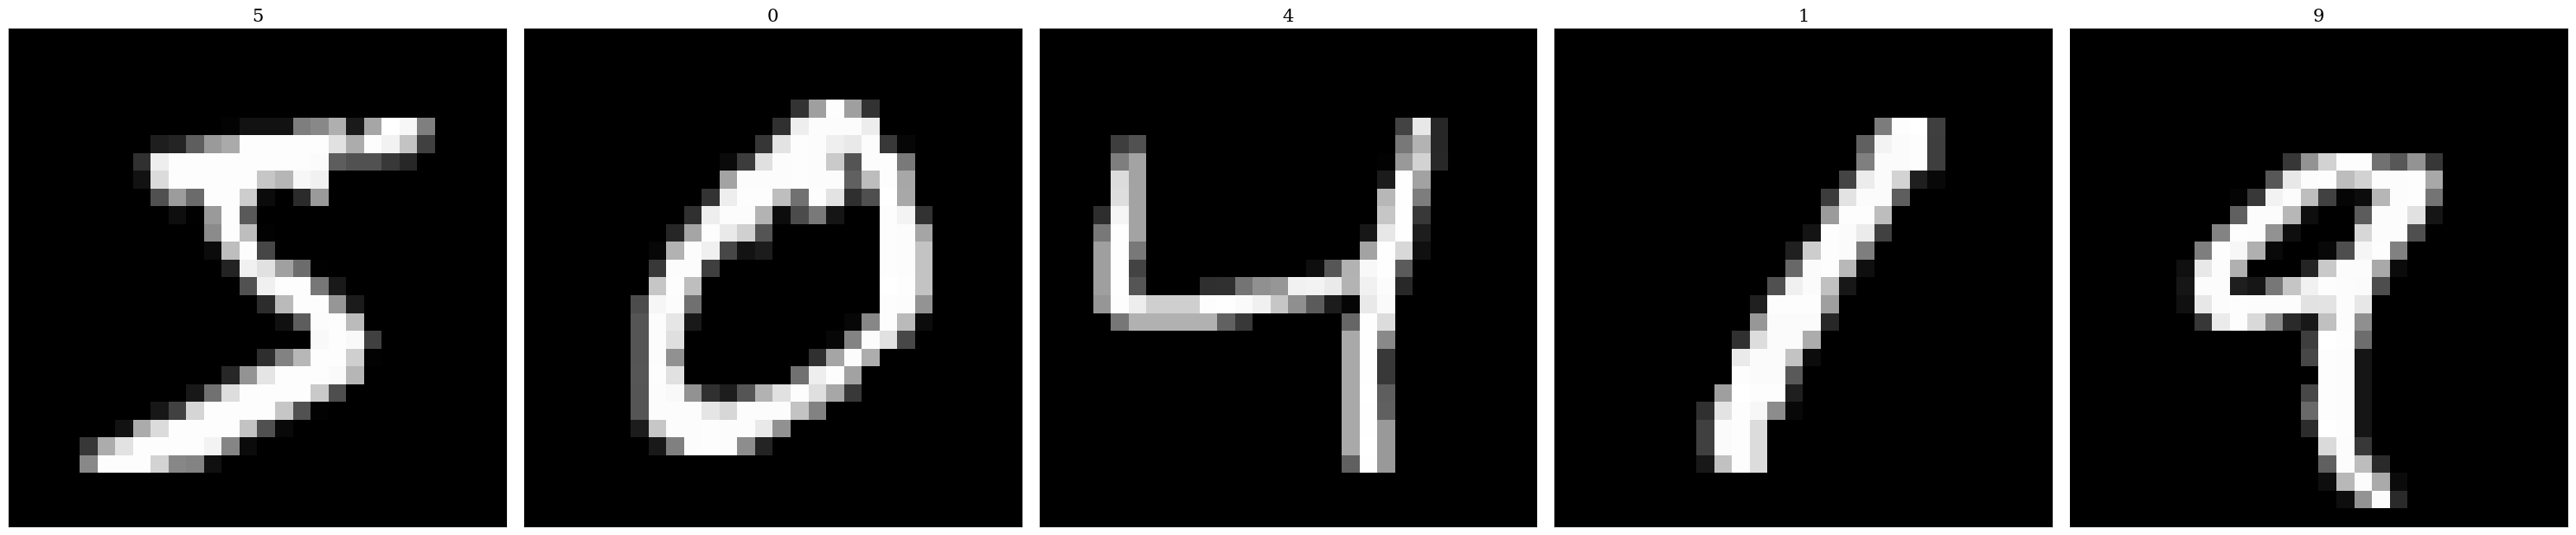

In [64]:
# Load MNIST dataset
X, y = get_MNIST_dataset()
y = onehot_decode_mnist_labels(y)
show_images(X[:5], y[:5])

# Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [65]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor  = torch.tensor(y_test, dtype=torch.long).to(device)

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [66]:
class NeuralNetwork_classification(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(X.shape[1], 256),
            nn.Sigmoid(),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [67]:
def accuracy(model):
    model.eval()  # set model to evaluation mode 
    correct = 0
    total = 0
    with torch.no_grad():  # disable gradient calculation for evaluation 
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, dim=1)  # class with highest score
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [68]:
def train_model(lr=0.01, num_epochs=10, lambd=1e-4):
    model = NeuralNetwork_classification().to(device)
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=lambd)  # lambd is regularization parameter for L2 regularization
    for _ in range(num_epochs):
        model.train()  # set model to training mode
        for images, labels in train_loader:
            # Move data to device (GPU if available, else CPU)
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()            # reset gradients to zero
            outputs = model(images)          # forward pass: compute predictions
            loss = criterion(outputs, labels)  # compute cross-entropy loss
            loss.backward()                 # backpropagate to compute gradients
            optimizer.step()                # update weights using SGD step 

    return accuracy(model)

In [69]:
learning_rates = np.logspace(-1, 1, 5)
lambdas = np.logspace(-10, -5, 6)

accuracies = np.zeros((len(learning_rates), len(lambdas)))
for i, lr in enumerate(learning_rates):
    for j, lambd in enumerate(lambdas):
        print(f"Training with learning rate: {lr} and lambda: {lambd}")
        acc = train_model(lr=lr, num_epochs=5, lambd=lambd)
        accuracies[i,j] = acc

Training with learning rate: 0.1 and lambda: 1e-10
Training with learning rate: 0.1 and lambda: 1e-09
Training with learning rate: 0.1 and lambda: 1e-08
Training with learning rate: 0.1 and lambda: 1e-07
Training with learning rate: 0.1 and lambda: 1e-06
Training with learning rate: 0.1 and lambda: 1e-05
Training with learning rate: 0.31622776601683794 and lambda: 1e-10
Training with learning rate: 0.31622776601683794 and lambda: 1e-09
Training with learning rate: 0.31622776601683794 and lambda: 1e-08
Training with learning rate: 0.31622776601683794 and lambda: 1e-07
Training with learning rate: 0.31622776601683794 and lambda: 1e-06
Training with learning rate: 0.31622776601683794 and lambda: 1e-05
Training with learning rate: 1.0 and lambda: 1e-10
Training with learning rate: 1.0 and lambda: 1e-09
Training with learning rate: 1.0 and lambda: 1e-08
Training with learning rate: 1.0 and lambda: 1e-07
Training with learning rate: 1.0 and lambda: 1e-06
Training with learning rate: 1.0 and 

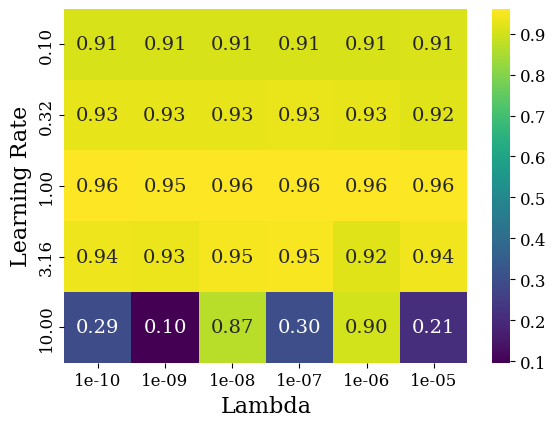

In [70]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#Heatmap
sns.heatmap(
    accuracies,
    fmt=".2f",
    annot=True,
    cmap="viridis",
    xticklabels=list(map(lambda x: f"{x:.0e}", lambdas)),
    yticklabels=list(map(lambda x: f"{x:.2f}", learning_rates)),

)
plt.xlabel("Lambda")
plt.ylabel("Learning Rate")
plt.show()

## Test PyTorch for regression task

In [71]:
# Autoreload
%load_ext autoreload
%autoreload 1
%aimport utils.neural_network, utils.training, utils.step_methods, utils.cost_functions, utils.activation_functions, utils.utils

# Imports
from utils.neural_network import NeuralNetwork
import numpy as np
import matplotlib.pyplot as plt
from utils.training import TrainingMethod, StochasticGradientDescent, GradientDescent
from utils.step_methods import StepMethod, RMSpropStep, AdamStep
from utils.cost_functions import MSE
from utils.activation_functions import Sigmoid, Identity
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from utils.utils import generate_dataset

plt.style.use('./utils/_plot_style.mplstyle')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
# Generate dataset
np.random.seed(124)

n = 300
x, y = generate_dataset(num=n)
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2,random_state=44)
num_nodes = 50
num_hidden_layers = [1,2]

# Define training methods
training_methods: list[tuple[str, type[TrainingMethod], tuple[int, int]]] = [
    "SGD",
    "GD",
]

# Step methods
step_methods: list[tuple[str, StepMethod]] = [
    "RMSprop", 
    "ADAM"
]

In [73]:
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device).float()
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device).float()
x_test_tensor  = torch.tensor(x_test, dtype=torch.float32).to(device).float()
y_test_tensor  = torch.tensor(y_test, dtype=torch.long).to(device).float()

train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
train_loader_SGD = DataLoader(train_dataset, batch_size=60, shuffle=True)
train_loader_GD = DataLoader(train_dataset, shuffle=False)

test_dataset = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, shuffle=False)

In [74]:
class NeuralNetwork_regression(nn.Module):
    def __init__(self,num_nodes,num_hidden_layers):
        super().__init__()

        model_layers = [nn.Linear(1,num_nodes),nn.Sigmoid()]
        for i in range(num_hidden_layers-1): 
            model_layers.append(nn.Linear(num_nodes,num_nodes))
            model_layers.append(nn.Sigmoid())
        model_layers.append(nn.Linear(num_nodes,1))

        self.linear_stack = nn.Sequential(*model_layers)

    def forward(self, x):
        out = self.linear_stack(x)
        return out
    
    def testing_MSE(self): 
        with torch.no_grad():  # disable gradient calculation for evaluation 
            input, target = test_dataset.tensors
            output = self.linear_stack(input)
        return torch.mean((target - output)**2)/len(target)
            
    
    def train_model_regression(self,lr=0.01, num_epochs=3000, lambd=0,training_method = "SGD",step_method = "ADAM"):   # train NN model for regression
        criterion = nn.MSELoss(reduction='mean')

        if training_method == "SGD": 
            loader = train_loader_SGD
            n_batches = 5   # define number of batches, so the learning rate can be divided by it (corresponds then to our neural network code)
        else: 
            loader = train_loader_GD
            n_batches = 1

        if step_method == "ADAM":
            optimizer = optim.Adam(self.parameters(), lr=lr/n_batches, weight_decay=lambd) # lambd is regularization parameter for L2 regularization
        if step_method=="RMSprop": 
            optimizer = optim.RMSprop(self.parameters(), alpha = 0.9,lr=lr/n_batches, weight_decay=lambd) # lambd is regularization parameter for L2 regularization

        optimizer = optim.SGD(self.parameters(), lr=lr/n_batches, weight_decay=lambd)  
        for _ in range(num_epochs):
            self.train()  # set model to training mode

            for input, target in loader: 
                optimizer.zero_grad()            # reset gradients to zero
                outputs = self.linear_stack(input)          # forward pass: compute predictions
                loss = criterion(outputs,target)  # compute MSE
                loss.backward()                 # backpropagate to compute gradients
                optimizer.step()                # update weights using SGD step 

        return self.testing_MSE()

In [75]:
filepath_1 = "../data/best_learning_rate_SGD_final.npy"
filepath_2 = "../data/best_learning_rate_GD_final.npy"

best_learning_rates_SGD = np.load(filepath_1)
best_learning_rates_GD = np.load(filepath_2)

In [76]:
n_learning_rates = 9
num_iterations = 3000
pytorch_mse_data = np.zeros((len(num_hidden_layers), len(training_methods),len(step_methods)))

# Analyze mse vs. learning rates for each combination of model, training method, and step method
for i in range(len(num_hidden_layers)):
    print(num_hidden_layers[i])
    for j, training_method_name in enumerate(training_methods):
        for l, step_method_name in enumerate(step_methods): 
            print(".", end="")
            np.random.seed(124)

            if training_method_name == "SGD": 
                best_lr = best_learning_rates_SGD
            else: 
                best_lr = best_learning_rates_GD

            model = NeuralNetwork_regression(num_nodes, num_hidden_layers[i])
            mse_data = model.train_model_regression(lr = best_lr[i,l],training_method = training_method_name,step_method = step_method_name)
            pytorch_mse_data[i][j][l] = mse_data


1
....2
....

In [77]:
print("PyTorch MSE for SGD: ",pytorch_mse_data[:,0,:]) 
print("PyTorch MSE for GD: ",pytorch_mse_data[:,1,:]) 

PyTorch MSE for SGD:  [[8.67160816e-06 6.60381602e-07]
 [1.26218629e-06 1.00090085e-06]]
PyTorch MSE for GD:  [[1.99035389e-06 1.90446235e-06]
 [1.24771179e-06 1.23170548e-06]]
